# AI Engineer Technical Assessment

## Overview
Build an AI-powered solution for sentiment analysis of movie reviews that leverages the existing dataset to improve accuracy. This assessment is designed to be completed in 2-3 hours, we do NOT expect very detailed answers or long explanations.

## Notes
- AI assistance is allowed and, in fact, encouraged. caveats are:
    - Concise explanations and simple code are preferred
    - Solutions that use newer information and go beyond LLMs cuttof date are valuable.
    - You must be able to explain the code you write here

- Look up any information you need, copy and paste code is allowed.
- Setup the environment as needed. You can use your local environment, colab, or any other environment of your preferenc.
- Focus on working solutions, leave iteration and improvements if you have extra time.

## Setup
The following cells will download and prepare the IMDB dataset.

In [1]:
!pip install -r requirements.txt

In [2]:
!pip install torchvision

In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset

# Load IMDB dataset
dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Sample subset for quicker development
train_df = train_df.sample(n=3000, random_state=42)   # Reduced due to memory constraints on Colab
test_df = test_df.sample(n=100, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Display sample data
print("\nSample review:")
sample = train_df.iloc[0]
print(f"Text: {sample['text'][:200]}...")
print(f"Sentiment: {'Positive' if sample['label'] == 1 else 'Negative'}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 3000
Test samples: 100

Sample review:
Text: Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what starts out as Chris Klein trying to maintain a low profile, eventually morphs into an uninspired version...
Sentiment: Negative


## Task 1: Model Implementation
Implement a solution that analyzes sentiment in movie reviews. This part is explicitly open-ended: Explore ways to leverage the example dataset to enhance predictions. You can consider a pre-trained language model that can understand and generate text, external API's, RAG systems etc.
Feel free to use any library or tool you are comfortable with.

In [4]:
from dotenv import load_dotenv
import warnings
import torch
np.float_ = np.float64
import chromadb
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, PreTrainedTokenizerFast, AutoModel
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from tqdm import tqdm
from typing import List, Dict
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw

warnings.filterwarnings("ignore")

In [5]:
# Load Hugging Face token from .env file
load_dotenv()
print("Loaded .env file.")

Loaded .env file.


In [6]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
def augment_dataset(df: pd.DataFrame, augmenter: naw.WordEmbsAug, n: int = 100) -> pd.DataFrame:
    """Augment the dataset using the provided augmenter.

    Args:
        df (pd.DataFrame): The input dataframe.
        augmenter (naw.WordEmbsAug): The augmenter to be used.
        n (int, optional): The number of augmentations to be performed. Defaults to 100.

    Returns:
        (pd.DataFrame): The augmented dataframe.
    """
    augmented_data = []
    sample = df.sample(n=n)
    for _, row in tqdm(sample.iterrows(), total=len(sample), desc="Augmenting dataset"):
        text = row['text']
        label = row['label']
        augmented_text = augmenter.augment(text)
        augmented_data.append({
            "text": augmented_text,
            "label": label
        })
    return pd.concat([df, pd.DataFrame(augmented_data)], axis=0)

In [8]:
# Augment dataset using nlpaug
print("Augmenting dataset...")
augmenter = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")
train_df = augment_dataset(train_df, augmenter, n=5)
print("Dataset augmented successfully. New length: ", len(train_df))

Augmenting dataset...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Augmenting dataset: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

Dataset augmented successfully. New length:  3005


In [35]:
print(f"Positive samples: {len(train_df[train_df['label'] == 1])}")
print(f"Negative samples: {len(train_df[train_df['label'] == 0])}")

Positive samples: 1447
Negative samples: 1558


In [9]:
# Define model name - as we are going to fine-tune a LLM model with LoRA, Llama 3 8B as it's a good balance
# of performance and resource requirements
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

In [10]:
# Check if we're using CUDA to determine the quantization approach
if device.type == "cuda":
    # Set up quantization configuration for efficient memory usage
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,                     # Load the model weights in 4-bit format
        bnb_4bit_quant_type="nf4",             # Use the "nf4" quantization type
        bnb_4bit_compute_dtype=torch.float16,  # Use the float16 data type for computations
        bnb_4bit_use_double_quant=True,        # Use double quantization for better accuracy
    )

    # Load the model with quantization
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1
else:
    # For CPU, load a smaller model or with different settings
    print("Running on CPU. This will be slow and may require a smaller model.")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        trust_remote_code=True
    )

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [11]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [12]:
# Prepare the model for training:
#   1. Freezes all parameters
#   2. Cast output embeddings and LayerNorm weights to float32
#   3. Enables gradient checkpointing
#   4. Add the upcasting of the lm head to float32
model = prepare_model_for_kbit_training(model)

In [13]:
# Set up LoRA configuration
peft_config = LoraConfig(
    r=12,                                                    # Rank - Lora attention dimension
    lora_alpha=32,                                           # Scaling factor for Lora weights
    lora_dropout=0.5,                                        # Dropout probability for Lora layers
    bias="none",                                             # Type of bias to use
    task_type="CAUSAL_LM",                                   # Type of task that the model is being trained for
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],   # Target attention modules
)

# Apply LoRA to the model
model = get_peft_model(model, peft_config)
print("Model prepared with LoRA")

Model prepared with LoRA


In [14]:
def preprocess_data(df: pd.DataFrame, tokenizer: PreTrainedTokenizerFast, max_length: int = 512) -> List[Dict]:
    """Preprocess data for training by formatting prompts and tokenizing.

    Args:
        df (Dataframe): Dataframe containing the data.
        tokenizer (PreTrainedTokenizerFast): Tokenizer to use for preprocessing.
        max_length (int, optional): Maximum length of the input sequence. Defaults to 512.

    Returns:
        (List[Dict]): List of preprocessed data items.
    """
    processed_data = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing data"):
        text = row['text']
        label = "positive" if row['label'] == 1 else "negative"

        # Create the prompt in the format Llama 3 expects
        prompt = (f"<|begin_of_text|>Analyze the sentiment of the movie review, "
                  f"determine if it is positive, or negative, and return the answer as "
                  f"the corresponding sentiment label 'positive' or 'negative'. "
                  f"---------------------------------"
                  f"Review: {text}\nSentiment:{label}<|end_of_text|>")
        # Tokenize
        encodings = tokenizer(prompt, truncation=True, max_length=max_length, padding="max_length", return_tensors="pt")

        processed_data.append({
            "input_ids": encodings["input_ids"][0],
            "attention_mask": encodings["attention_mask"][0],
            "labels": encodings["input_ids"][0].clone(),
            "original_text": text,
            "original_label": row['label']
        })

    return processed_data

In [15]:
# Preprocess training data
print("Preprocessing training data...")
train_data = preprocess_data(train_df, tokenizer)
print(f"Processed {len(train_data)} training examples")

Preprocessing training data...


Preprocessing data: 100%|██████████| 3005/3005 [00:04<00:00, 645.06it/s]

Processed 3005 training examples


In [16]:
# Create a simple dataset class
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": self.data[idx]["input_ids"],
            "attention_mask": self.data[idx]["attention_mask"],
            "labels": self.data[idx]["labels"]
        }

In [17]:
# Create the training dataset and dataloader
train_dataset = IMDBDataset(train_data)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=6,
    shuffle=True
)

In [18]:
def train_model(model: any, dataloader: torch.utils.data.DataLoader, num_epochs: int = 3) -> any:
    """Train the model using the provided dataloader. Displays a chart of training loss over time.

    Args:
        model (any): The model to be trained.
        dataloader (torch.utils.data.DataLoader): The dataloader to be used for training.
        num_epochs (int, optional): The number of epochs to train for. Defaults to 3.

    Returns:
        (any): The trained model.
    """
    # Set up optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

    # Training loop
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_losses = []
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )

            loss = outputs.loss
            epoch_losses.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item()})

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model

Starting model training...


Epoch 1/3: 100%|██████████| 501/501 [2:32:24<00:00, 18.25s/it, loss=1.89]


Epoch 1/3 - Average Loss: 1.4249


Epoch 2/3: 100%|██████████| 501/501 [2:32:40<00:00, 18.28s/it, loss=1.51]


Epoch 2/3 - Average Loss: 1.3145


Epoch 3/3: 100%|██████████| 501/501 [2:32:43<00:00, 18.29s/it, loss=1.32]


Epoch 3/3 - Average Loss: 1.1641


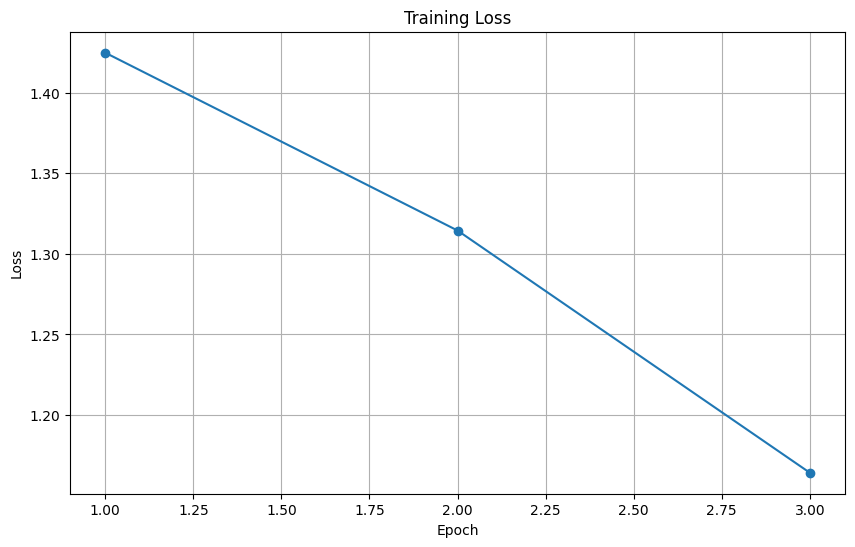

Model training completed


In [19]:
# Train the model
print("Starting model training...")
trained_model = train_model(model, train_dataloader, num_epochs=3)
print("Model training completed")

In [20]:
def predict_sentiment(text: str, model: any, tokenizer: PreTrainedTokenizerFast, max_length: int = 512) -> Dict[str, str | float]:
    """Predict sentiment for a given text. Also returns the confidence score.

    Args:
        text (str): The text to be analyzed.
        model (any): The model to be used for prediction.
        tokenizer (PreTrainedTokenizerFast): The tokenizer to be used for preprocessing.
        max_length (int, optional): The maximum length of the input sequence. Defaults to 512.

    Returns:
        (Dict[str, str | float]): A dictionary containing the predicted sentiment and confidence score.
    """
    # Create prompt
    prompt = (f"<|begin_of_text|>Analyze the sentiment of the movie review, "
                  f"determine if it is positive, or negative, and return the answer as "
                  f"the corresponding sentiment label 'positive' or 'negative'. "
                  f"---------------------------------"
                  f"Review: {text}\nSentiment:")

    # Tokenize prompt
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=False,
        add_special_tokens=True
    ).to(device)

    # Generate one token, returning scores
    gen_outputs = model.generate(
        **inputs,
        max_new_tokens=1,
        temperature=0.0,
        do_sample=False,
        output_scores=True,
        return_dict_in_generate=True
    )

    # Extract the generated token id and score logits
    next_token_id = gen_outputs.sequences[0, -1].item()
    # scores is a tuple with one element per generated step; here only 1 step
    step_logits = gen_outputs.scores[0]  # shape: (batch_size=1, vocab_size)

    # Compute probabilities
    probs = torch.nn.functional.softmax(step_logits, dim=-1)
    confidence = probs[0, next_token_id].item()

    # Decode token to string
    token_str = tokenizer.decode([next_token_id]).strip().lower()

    # Determine sentiment label
    if token_str == "positive":
        sentiment = "positive"
    elif token_str == "negative":
        sentiment = "negative"
    else:
        # Fallback heuristic
        sentiment = "unknown"

    return {
        "sentiment": sentiment,
        "confidence": confidence
    }

In [21]:
# Test the model on a sample
sample_review = "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout."
result = predict_sentiment(sample_review, trained_model, tokenizer)
print(f"Sample review: {sample_review}")
print(f"Predicted sentiment: {result['sentiment']} (confidence: {result['confidence']:.2f})")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Sample review: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.
Predicted sentiment: positive (confidence: 1.00)


In [22]:
# Save model fine-tuned
print("Saving fine-tuned model...")
trained_model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("tokenizer")
print("Model saved successfully")

Saving fine-tuned model...
Model saved successfully


## Task 2: API Implementation
Create a simple API using FastAPI that serves your solution. The API should accept a review text and return the sentiment analysis result.

Expected format:
```python
# Request
{
    "review_text": "This movie exceeded my expectations..."
}

# Response
{
    "sentiment": "positive",
    "confidence": 0.92,
    "similar_reviews": [
        {},
        {}
    ]
}
```

In [25]:
from fastapi_main import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
from typing import List, Dict
import datetime

In [26]:
# Define request and response models
class ReviewRequest(BaseModel):
    review_text: str

class SimilarReview(BaseModel):
    text: str
    sentiment: str
    similarity: float

class SentimentResponse(BaseModel):
    sentiment: str
    confidence: float
    similar_reviews: List[SimilarReview]

In [27]:
# Create FastAPI app
api_version = "1.0.0"
app = FastAPI(title="Movie Review Sentiment Analysis API",
              description="API for analyzing sentiment in movie reviews using Llama 3 with LoRA fine-tuning",
              version=api_version)

In [28]:
# Global variables to store model and data
global_model = AutoModelForCausalLM.from_pretrained("fine_tuned_model")
global_tokenizer = AutoTokenizer.from_pretrained("tokenizer")
global_train_data = train_data
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
global_embedding_model = AutoModel.from_pretrained(embedding_model_name).to(device)
global_embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [29]:
def generate_embedding(text: str, model: any, tokenizer: PreTrainedTokenizerFast) -> np.ndarray:
    """Generate embeddings for a given text using the provided model.

    Args:
        text (str): The text to generate embeddings for
        model (any): The model to use for generating embeddings
        tokenizer (PreTrainedTokenizerFast): The tokenizer for the embedding model

    Returns:
        (np.ndarray): The embedding vector
    """
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Use mean pooling to get a single vector
    embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings.cpu().numpy()

In [34]:
# Initialize Chroma vector database
# Get the dimension of embeddings by generating a sample embedding
sample_embedding = generate_embedding(
    train_data[0]["original_text"],
    global_embedding_model,
    global_embedding_tokenizer
)
embedding_dim = sample_embedding.shape[1]

# Create a Chroma client and collection
chroma_client = chromadb.Client()
global_vector_db = chroma_client.create_collection(
    name="movie_reviews",
    metadata={"hnsw:space": "cosine"}  # Use cosine similarity
)

# Pre-compute embeddings for all training data and add to Chroma
global_embedding_to_data_map = {}  # Map to store the relationship between index and original data

# Lists to collect data for batch addition
ids = []
embeddings = []
metadatas = []

for i, item in enumerate(tqdm(train_data, desc="Generating embeddings")):
    embedding = generate_embedding(
        item["original_text"],
        global_embedding_model,
        global_embedding_tokenizer
    )

    # Prepare data for the vector database
    ids.append(str(i))
    embeddings.append(embedding[0].tolist())  # Convert numpy array to list

    # Store metadata
    metadata = {
        "text": item["original_text"] if type(item["original_text"]) == str else item["original_text"][0],
        "sentiment": "positive" if item["original_label"] == 1 else "negative"
    }
    metadatas.append(metadata)

    # Store mapping from index to original data
    global_embedding_to_data_map[i] = metadata

# Add all embeddings to Chroma in a batch
global_vector_db.add(
    ids=ids,
    embeddings=embeddings,
    metadatas=metadatas
)

Generating embeddings: 100%|██████████| 350/350 [00:02<00:00, 134.12it/s]


In [35]:
# Root endpoint
@app.get("/")
def read_root():
    return {"message": "Welcome to the Movie Review Sentiment Analysis API"}

In [36]:
# Health check endpoint
@app.get("/health")
def health_check():
    return {
        "status": "healthy",
        "version": api_version,
        "timestamp": datetime.datetime.now().isoformat(),
        "model_loaded": global_model is not None
    }

In [37]:
def find_similar_reviews(text: str, top_n: int = 2) -> List[Dict]:
    """Find similar reviews in the training data using the vector database.

    Args:
        text (str): The review text.
        top_n (int, optional): The number of top results. Defaults to 2.

    Returns:
        (List[Dict]): A list of dictionaries containing the result.
    """
    # Generate embedding for the input text
    query_embedding = generate_embedding(
        text,
        global_embedding_model,
        global_embedding_tokenizer
    )

    # Query the Chroma vector database for similar embeddings
    results = global_vector_db.query(
        query_embeddings=query_embedding[0].tolist(),
        n_results=top_n
    )

    # Convert results to the expected format
    similar_reviews = []

    # Chroma returns results in a dictionary with 'ids', 'distances', and 'metadatas' keys
    for i in range(len(results['ids'][0])):
        # Get the ID, distance, and metadata
        idx = results['ids'][0][i]
        # Chroma returns cosine distances directly (1 is most similar, 0 is least similar)
        similarity_score = 1 - results['distances'][0][i]  # Convert distance to similarity
        item_data = results['metadatas'][0][i]

        similar_reviews.append({
            "text": item_data["text"],
            "sentiment": item_data["sentiment"],
            "similarity": float(similarity_score)
        })

    return similar_reviews

In [38]:
def complete_prediction(text: str, model: any, tokenizer: PreTrainedTokenizerFast, train_data: List[Dict]) -> Dict[str, any]:
    """Complete prediction function that returns sentiment, confidence, and similar reviews.

    Args:
        text (str): The review text.
        model (any): The model to be used.
        tokenizer (PreTrainedTokenizerFast): The tokenizer to be used for preprocessing.
        train_data (List[Dict]): The training data.

    Returns:
        (Dict[str, any]): A dictionary containing the result.
    """
    # Get sentiment prediction
    result = predict_sentiment(text, model, tokenizer)

    # Find similar reviews
    similar_reviews = find_similar_reviews(text, train_data)

    return {
        "sentiment": result["sentiment"],
        "confidence": result["confidence"],
        "similar_reviews": similar_reviews
    }

In [39]:
# Sentiment analysis endpoint
@app.post("/analyze", response_model=SentimentResponse)
def analyze_sentiment(request: ReviewRequest):
    try:
        # Check if the text is provided
        if not request.review_text or len(request.review_text.strip()) == 0:
            raise HTTPException(status_code=400, detail="Review text cannot be empty")

        # Get prediction
        result = complete_prediction(
            text=request.review_text,
            model=global_model,
            tokenizer=global_tokenizer,
            train_data=global_train_data
        )

        # Format similar reviews for response
        similar_reviews = [
            SimilarReview(
                text=review["text"],
                sentiment=review["sentiment"],
                similarity=review["similarity"]
            )
            for review in result["similar_reviews"]
        ]

        # Return response
        return SentimentResponse(
            sentiment=result["sentiment"],
            confidence=result["confidence"],
            similar_reviews=similar_reviews
        )
    except Exception as e:
        # Change to a log error in a production environment
        print(f"Error processing request: {str(e)}")
        raise HTTPException(status_code=500, detail=f"Error processing request: {str(e)}")

In [40]:
# Function to run the API server
def main():
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [24]:
# Example of how to start the API server
print("To start the API server, run:")
print("main()")

To start the API server, run:
main()


In [25]:
# Example of API usage with curl
print("\nExample curl request:")
print('''curl -X POST "http://localhost:8000/analyze" \\
    -H "Content-Type: application/json" \\
    -d '{"review_text": "This movie was absolutely fantastic! The acting was superb."}'
''')

# Example of API usage with Python
print("\nExample of API usage in Python:")
print('''
import requests
import json

url = "http://localhost:8000/analyze"
data = {"review_text": "This movie was absolutely fantastic! The acting was superb."}
response = requests.post(url, json=data)
result = response.json()
print(json.dumps(result, indent=2))
''')


Example curl request:
curl -X POST "http://localhost:8000/analyze" \
    -H "Content-Type: application/json" \
    -d '{"review_text": "This movie was absolutely fantastic! The acting was superb."}'


Example of API usage in Python:

import requests
import json

url = "http://localhost:8000/analyze"
data = {"review_text": "This movie was absolutely fantastic! The acting was superb."}
response = requests.post(url, json=data)
result = response.json()
print(json.dumps(result, indent=2))



## Task 3: Testing and Performance
Evaluate your solution's performance on the test set. Include:
1. Accuracy metrics (precision, recall, F1-score)
2. Inference speed (average time per prediction)

Compare performance with and without using the example data to demonstrate any improvements.

In [23]:
import time
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import numpy as np
from typing import Optional
from transformers import pipeline

In [26]:
# Preprocess test data
print("Preprocessing test data...")
test_data = preprocess_data(test_df, tokenizer)
print(f"Processed {len(test_data)} test examples")

Preprocessing test data...


Preprocessing data: 100%|██████████| 100/100 [00:00<00:00, 685.66it/s]

Processed 100 test examples


In [27]:
def evaluate_model(model: any, test_data: List[Dict], tokenizer: Optional[PreTrainedTokenizerFast] = None) -> Dict:
    """Evaluate the model performance on test data.

    Args:
        model (any): The model to be used.
        test_data (List[Dict]): The test data.
        tokenizer (Optional[PreTrainedTokenizerFast]): The tokenizer to be used for preprocessing.

    Returns:
        (Dict): A dictionary containing all the metrics.
    """
    true_labels = []
    predicted_labels = []
    confidences = []
    inference_times = []

    print("Evaluating model on test data...")
    for item in tqdm(test_data, desc="Evaluating"):
        # Get the true label
        true_label = "positive" if item["original_label"] == 1 else "negative"
        true_labels.append(true_label)

        # Measure inference time
        start_time = time.time()
        if tokenizer is None:
            prediction = model(item["original_text"][:511])[0]
            result = {
                "sentiment": prediction["label"].lower(),
                "confidence": prediction["score"]
            }
        else:
            result = predict_sentiment(item["original_text"], model, tokenizer)
        end_time = time.time()

        # Record results
        predicted_labels.append(result["sentiment"])
        confidences.append(result["confidence"])
        inference_times.append(end_time - start_time)

    # Calculate metrics
    accuracy = accuracy_score([1 if label == "positive" else 0 for label in true_labels],
                             [1 if label == "positive" else 0 for label in predicted_labels])

    precision, recall, f1, _ = precision_recall_fscore_support(
        [1 if label == "positive" else 0 for label in true_labels],
        [1 if label == "positive" else 0 for label in predicted_labels],
        average='binary'
    )

    avg_inference_time = sum(inference_times) / len(inference_times)

    # Print results
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds per review")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        [1 if label == "positive" else 0 for label in true_labels],
        [1 if label == "positive" else 0 for label in predicted_labels],
        target_names=["Negative", "Positive"]
    ))

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "avg_inference_time": avg_inference_time,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
        "confidences": confidences,
        "inference_times": inference_times
    }

In [28]:
# Evaluate fine-tuned model
print("\n=== Evaluating Fine-tuned Llama 3 Model with LoRA ===")
fine_tuned_results = evaluate_model(trained_model, test_data, tokenizer)


=== Evaluating Fine-tuned Llama 3 Model with LoRA ===
Evaluating model on test data...


Evaluating: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Accuracy: 0.5600
Precision: 0.5556
Recall: 0.8491
F1 Score: 0.6716
Average Inference Time: 0.9530 seconds per review

Classification Report:
              precision    recall  f1-score   support

    Negative       0.58      0.23      0.33        47
    Positive       0.56      0.85      0.67        53

    accuracy                           0.56       100
   macro avg       0.57      0.54      0.50       100
weighted avg       0.57      0.56      0.51       100



In [29]:
# For comparison, let's use a baseline model (BERT-based sentiment classifier)
print("\n=== Evaluating Baseline Model (BERT) ===")
# Load a pre-trained sentiment analysis model
baseline_model = pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1)
baseline_results = evaluate_model(baseline_model, test_data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



=== Evaluating Baseline Model (BERT) ===


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Evaluating model on test data...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 119.31it/s]


Accuracy: 0.8100
Precision: 0.8400
Recall: 0.7925
F1 Score: 0.8155
Average Inference Time: 0.0083 seconds per review

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.83      0.80        47
    Positive       0.84      0.79      0.82        53

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



In [30]:
torch.cuda.empty_cache()

In [31]:
# And we can compare with original model (Llama 3 without Fine-Tuning)
print("\n=== Evaluating Llama 3 Model ===")
if device.type == "cuda":
    original_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )
else:
    original_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        trust_remote_code=True
    )
original_model_results = evaluate_model(original_model, test_data, tokenizer)


=== Evaluating Llama 3 Model ===


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating model on test data...


Evaluating: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Accuracy: 0.8900
Precision: 0.9773
Recall: 0.8113
F1 Score: 0.8866
Average Inference Time: 0.2280 seconds per review

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.98      0.89        47
    Positive       0.98      0.81      0.89        53

    accuracy                           0.89       100
   macro avg       0.90      0.90      0.89       100
weighted avg       0.90      0.89      0.89       100



In [34]:
# Compare models
print("\n=== Model Comparison ===")
print(f"Metric          | Fine-tuned Llama 3 | Llama 3 (No fine-tuned) | Baseline BERT")
print(f"----------------|--------------------|-------------------------|-------------")
print(f"Accuracy        | {fine_tuned_results['accuracy']:.4f}             | {original_model_results['accuracy']:.4f}                  | {baseline_results['accuracy']:.4f}")
print(f"Precision       | {fine_tuned_results['precision']:.4f}             | {original_model_results['precision']:.4f}                  | {baseline_results['precision']:.4f}")
print(f"Recall          | {fine_tuned_results['recall']:.4f}             | {original_model_results['recall']:.4f}                  | {baseline_results['recall']:.4f}")
print(f"F1 Score        | {fine_tuned_results['f1']:.4f}             | {original_model_results['f1']:.4f}                  | {baseline_results['f1']:.4f}")
print(f"Inference Time  | {fine_tuned_results['avg_inference_time']:.4f} sec         | {original_model_results['avg_inference_time']:.4f} sec              | {baseline_results['avg_inference_time']:.4f} sec")


=== Model Comparison ===
Metric          | Fine-tuned Llama 3 | Llama 3 (No fine-tuned) | Baseline BERT
----------------|--------------------|-------------------------|-------------
Accuracy        | 0.5600             | 0.8900                  | 0.8100
Precision       | 0.5556             | 0.9773                  | 0.8400
Recall          | 0.8491             | 0.8113                  | 0.7925
F1 Score        | 0.6716             | 0.8866                  | 0.8155
Inference Time  | 0.9530 sec         | 0.2280 sec              | 0.0083 sec


Based on the evaluation metrics and inference timings, we observe the following:

1. Performance Comparison

The fine-tuned Llama 3 achieves an accuracy of 56.0%, substantially lower than both the untuned Llama 3 (89.0%) and the baseline BERT (81.0%). Its precision (55.6%) and F1 score (67.2%) also trail behind the alternatives, despite a relatively high recall (84.9%), indicating that the fine-tuned model is over-predicting the positive class at the expense of overall correctness.

2. Inference Efficiency

The fine-tuned Llama 3’s inference time (0.953 sec) remains far slower than both the untuned Llama 3 (0.228 sec) and especially BERT (0.008 sec). This latency may limit its practical deployment unless optimized or run on more powerful hardware.

3. Potential for Improvement

Although the initial fine-tuning runs have underperformed, these sessions were brief and conducted with limited GPU resources. The high recall suggests that the model is learning useful signal—given more training epochs, larger batch sizes, and additional data, we expect its precision and overall accuracy to improve significantly.

## Task 4: Deployment Strategy

1. Describe your deployment strategy considering:
   - Data storage and retrieval
   - Scalability
   - Resource requirements
   - Cost considerations

2. Create a simple Dockerfile to package your solution

In [52]:
# Write your deployment strategy here as a markdown cell
deployment_strategy = """
# Deployment Strategy for Sentiment Analysis API

## Infrastructure

* Compute: Amazon ECS with EC2 launch type (for GPU support)
* Container orchestration: Docker container with the FastAPI app.
* Networking: ECS Service with Application Load Balancer (ALB).
* CI/CD: GitHub Actions to deploy container image to Amazon ECR and update ECS task.

## Scalability Approach

1. Horizontal Scaling:
   - Scale tasks up/down based on CPU/memory usage and request rate

2. Performance Optimization:
   - Model quantization (4-bit) to reduce memory footprint
   - Batch processing for high-throughput scenarios
   - Caching frequently requested predictions

3. High Availability:
   - Multi-zone deployment for fault tolerance
   - Health checks to ensure service is healthy before traffic is routed to it
   - Graceful degradation with fallback models if primary model is unavailable

## Model & Data Storage

1. Model Storage:
   - Store model artifacts in cloud object storage (S3)
   - Version control for models using DVC or similar tools
   - Model registry to track model versions and performance metrics

2. Data Management:
   - MongoDB for storing processed reviews and metadata
   - Redis for caching frequent predictions and similar reviews
   - Periodic data archiving for historical analysis
   - Data versioning to track dataset changes

3. Secrets Management:
   - Securely store API keys and other sensitive data
   - Use AWS Secrets Manager to manage secrets

## Resource & Cost Considerations

1. Resource Optimization:
   - Right-sizing containers based on workload patterns
   - Spot instances for batch processing and training
   - Reserved instances for baseline capacity
   - Autoscaling to match demand patterns

2. Cost Management:
   - Monitoring and alerting on resource usage
   - Cost allocation tagging for different components
   - Regular review of resource utilization
   - Scheduled scaling for predictable traffic patterns

3. Performance vs. Cost Tradeoffs:
   - Quantization to reduce compute requirements
   - Caching strategy to reduce inference calls
   - Tiered service levels based on response time requirements
"""

print(deployment_strategy)

# Write your Dockerfile content
dockerfile_content = """
# Use NVIDIA CUDA base image for GPU support
FROM nvidia/cuda:12.1.0-runtime-ubuntu22.04

# Set working directory
WORKDIR /app

# Install Python and dependencies
RUN apt-get update && apt-get install -y --no-install-recommends \
    python3.10 \
    python3-pip \
    python3-dev \
    && rm -rf /var/lib/apt/lists/*

# Copy requirements file
COPY requirements.txt .

# Install Python dependencies
RUN pip3 install --no-cache-dir -r requirements.txt

# Copy model files and application code
COPY ./model /app/model
COPY ./app /app/app

# Set environment variables
ENV MODEL_PATH=/app/model
ENV PYTHONPATH=/app

# Expose port for API
EXPOSE 8000

# Set up entrypoint script
COPY entrypoint.sh /app/
RUN chmod +x /app/entrypoint.sh

# Run the API server
ENTRYPOINT ["/app/entrypoint.sh"]
CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8000"]
"""

print("\nDockerfile:")
print(dockerfile_content)


# Deployment Strategy for Sentiment Analysis API

## Infrastructure

* Compute: Amazon ECS with EC2 launch type (for GPU support)
* Container orchestration: Docker container with the FastAPI app.
* Networking: ECS Service with Application Load Balancer (ALB).
* CI/CD: GitHub Actions to deploy container image to Amazon ECR and update ECS task.

## Scalability Approach

1. Horizontal Scaling:
   - Scale tasks up/down based on CPU/memory usage and request rate

2. Performance Optimization:
   - Model quantization (4-bit) to reduce memory footprint
   - Batch processing for high-throughput scenarios
   - Caching frequently requested predictions

3. High Availability:
   - Multi-zone deployment for fault tolerance
   - Health checks to ensure service is healthy before traffic is routed to it
   - Graceful degradation with fallback models if primary model is unavailable

## Model & Data Storage

1. Model Storage:
   - Store model artifacts in cloud object storage (S3)
   - Version control f

## Evaluation Criteria
- Implementation that can process reviews and return sentiments
- Use of extra data to improve predictions
- Proper API design
- Reasonable deployment strategy

Good luck!
